In [1]:
# Import data

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from hevisum_dataset import importDataset
import numpy as np


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might b

In [26]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from hevisum_dataset import importDataset
import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")

# 載入資料
center_tile = torch.load("./train_dataset_sep_v2/tiles.pt")
subtiles = torch.load("./train_dataset_sep_v2/subtiles.pt")
neighbor_tiles = torch.load("./train_dataset_sep_v2/neighbor_tiles.pt")
label = torch.load("./train_dataset_sep_v2/labels.pt")
meta = torch.load("./train_dataset_sep_v2/meta_info.pt")

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_25126/3077069298.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  center_tile = torch.load("./train_dataset_sep

In [83]:
# 正確方式

raw_coords = []
for _meta in meta:
    if _meta is not None:
        _, x, y = _meta
    else:
        x, y = 0, 0
    raw_coords.append([x, y])

raw_coords = np.array(raw_coords)


coord_scaler = StandardScaler()
normalized_coords = coord_scaler.fit_transform(raw_coords)
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

# ✅ 安全轉換：避免 ToTensor() 對 Tensor 失效
class SafeTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            return img  # 已是 Tensor，不再轉換
        return self.transform(img)

# ✅ Dataset 定義
class importDataset(Dataset):
    def __init__(self, center_tile, subtiles, neighbor_tiles, label, meta=None, transform=None):
        self.center_tile = center_tile
        self.subtiles = subtiles
        self.neighbor_tiles = neighbor_tiles
        self.label = label
        self.meta = meta if meta is not None else [None] * len(center_tile)

        self.transform = transform or SafeTransform()

    def __len__(self):
        return len(self.center_tile)

    def __getitem__(self, idx):
        # ✅ 安全轉換中心 tile
        center_tile = self.transform(self.center_tile[idx])  # shape: (3, H, W)

        # ✅ Subtiles: List of (H, W, 3)
        subtiles = torch.stack([self.transform(tile) for tile in self.subtiles[idx]])  # (9, 3, h, w)

        # ✅ Neighbor tiles: List of (H, W, 3)
        neighbor_tiles = torch.stack([self.transform(tile) for tile in self.neighbor_tiles[idx]])  # (8, 3, H, W)

        # ✅ Label
        label = torch.tensor(self.label[idx], dtype=torch.float32)

        # ✅ Normalized coordinates (x, y)
        meta = self.meta[idx]  # already normalized
        meta_tensor = torch.tensor(meta, dtype=torch.float)


        return {
            'center_tile': center_tile,
            'subtiles': subtiles,
            'neighbor_tiles': neighbor_tiles,
            'label': label,
            'coords': meta_tensor
        }

# ====== Step 2: 建立 Dataset ======
train_dataset = importDataset(
    center_tile=center_tile,
    subtiles=subtiles,
    neighbor_tiles=neighbor_tiles,
    label=label,
    meta=df_scaled[['x_norm', 'y_norm']].astype(float).to_numpy()
)

In [82]:
df_scaled

,slide_id,x,y,x_std,y_std,x_norm,y_norm
0,S_1,1554,1297,1.015115,0.468132,0.815877,0.585326
1,S_1,462,1502,-1.706209,1.191686,0.087392,0.754328
2,S_1,1488,1548,0.850639,1.354045,0.771848,0.792251
3,S_1,1725,1182,1.441256,0.062235,0.929953,0.490519
4,S_1,581,1113,-1.409655,-0.181303,0.166778,0.433636
...,...,...,...,...,...,...,...
8344,S_6,1173,842,0.935331,-1.162485,0.75,0.200299
8345,S_6,1237,775,1.479388,-1.608359,0.887931,0.100149
8346,S_6,903,953,-1.359909,-0.423799,0.168103,0.366218
8347,S_6,954,1310,-0.926364,1.951975,0.278017,0.899851


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def scale_meta(meta):
    """
    將 meta 資料依照 slide id 分組，對 x 與 y 分別做標準化（StandardScaler）與 0-1 正規化（MinMaxScaler）。
    
    參數:
        meta: list of tuple，格式如 [('S_1', 1554, 1297), ('S_1', 462, 1502), ...]
        
    回傳:
        DataFrame，除了原本的 slide_id、x、y 之外，還會新增四個欄位：
            - x_std, y_std: 標準化後的座標
            - x_norm, y_norm: 0-1 正規化後的座標
    """
    # 建立 DataFrame
    df = pd.DataFrame(meta, columns=['slide_id', 'x', 'y'])
    
    # 初始化新欄位
    df['x_std'] = None
    df['y_std'] = None
    df['x_norm'] = None
    df['y_norm'] = None
    
    # 依照 slide_id 分組後處理
    for slide, group in df.groupby('slide_id'):
        # 取出該組 x 與 y 資料（轉換為 2D array）
        x = group[['x']].values
        y = group[['y']].values
        
        # 標準化：StandardScaler
        standard_scaler_x = StandardScaler()
        standard_scaler_y = StandardScaler()
        x_std = standard_scaler_x.fit_transform(x)
        y_std = standard_scaler_y.fit_transform(y)
        
        # 正規化：MinMaxScaler
        minmax_scaler_x = MinMaxScaler()
        minmax_scaler_y = MinMaxScaler()
        x_norm = minmax_scaler_x.fit_transform(x)
        y_norm = minmax_scaler_y.fit_transform(y)
        
        # 將結果填回 DataFrame（flatten array 以便存入欄位）
        df.loc[group.index, 'x_std'] = x_std.flatten()
        df.loc[group.index, 'y_std'] = y_std.flatten()
        df.loc[group.index, 'x_norm'] = x_norm.flatten()
        df.loc[group.index, 'y_norm'] = y_norm.flatten()
    
    return df

df_scaled = scale_meta(meta)
print(df_scaled)


     slide_id     x     y     x_std     y_std    x_norm    y_norm
0         S_1  1554  1297  1.015115  0.468132  0.815877  0.585326
1         S_1   462  1502 -1.706209  1.191686  0.087392  0.754328
2         S_1  1488  1548  0.850639  1.354045  0.771848  0.792251
3         S_1  1725  1182  1.441256  0.062235  0.929953  0.490519
4         S_1   581  1113 -1.409655 -0.181303  0.166778  0.433636
...       ...   ...   ...       ...       ...       ...       ...
8344      S_6  1173   842  0.935331 -1.162485      0.75  0.200299
8345      S_6  1237   775  1.479388 -1.608359  0.887931  0.100149
8346      S_6   903   953 -1.359909 -0.423799  0.168103  0.366218
8347      S_6   954  1310 -0.926364  1.951975  0.278017  0.899851
8348      S_6  1186   864  1.045843 -1.016079  0.778017  0.233184

[8349 rows x 7 columns]


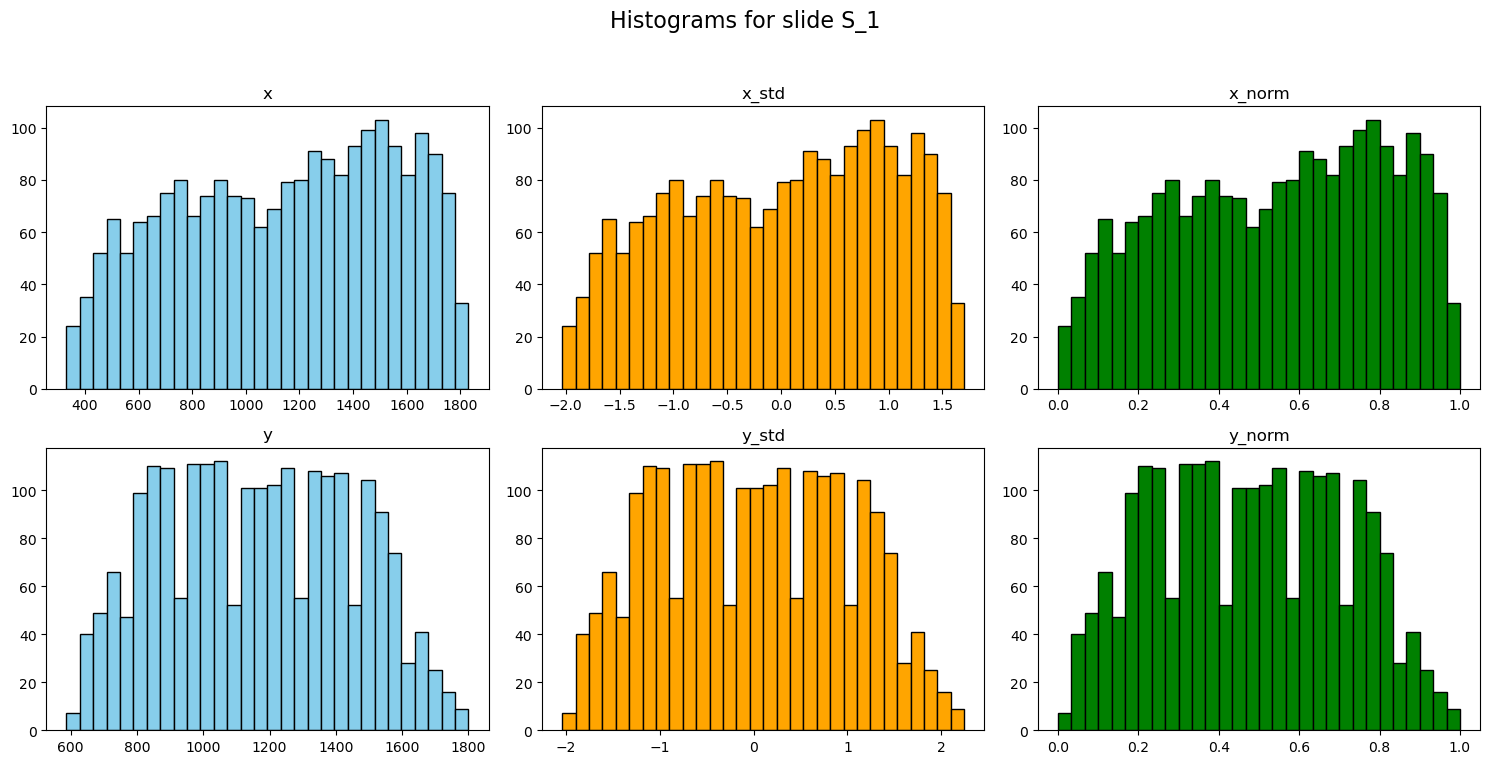

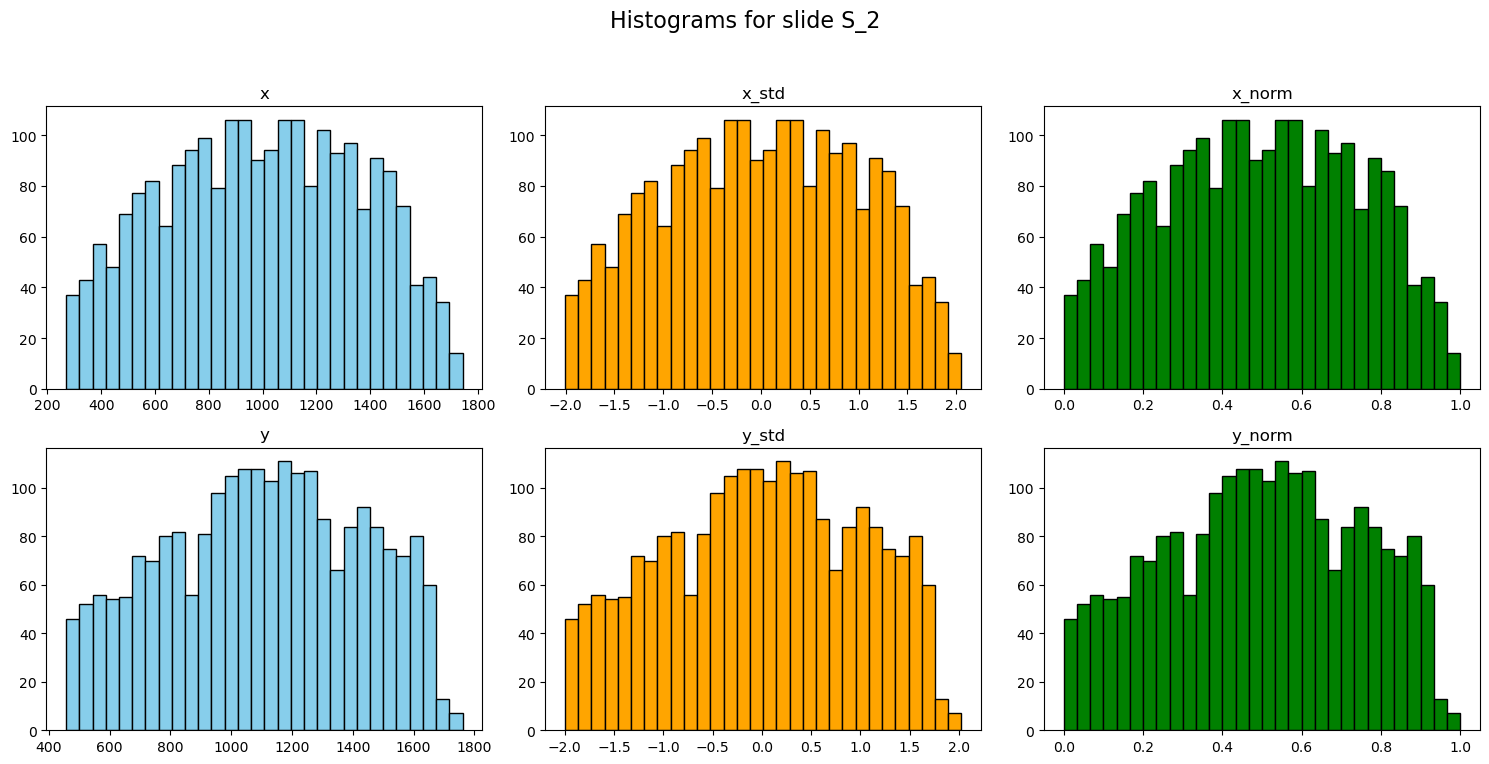

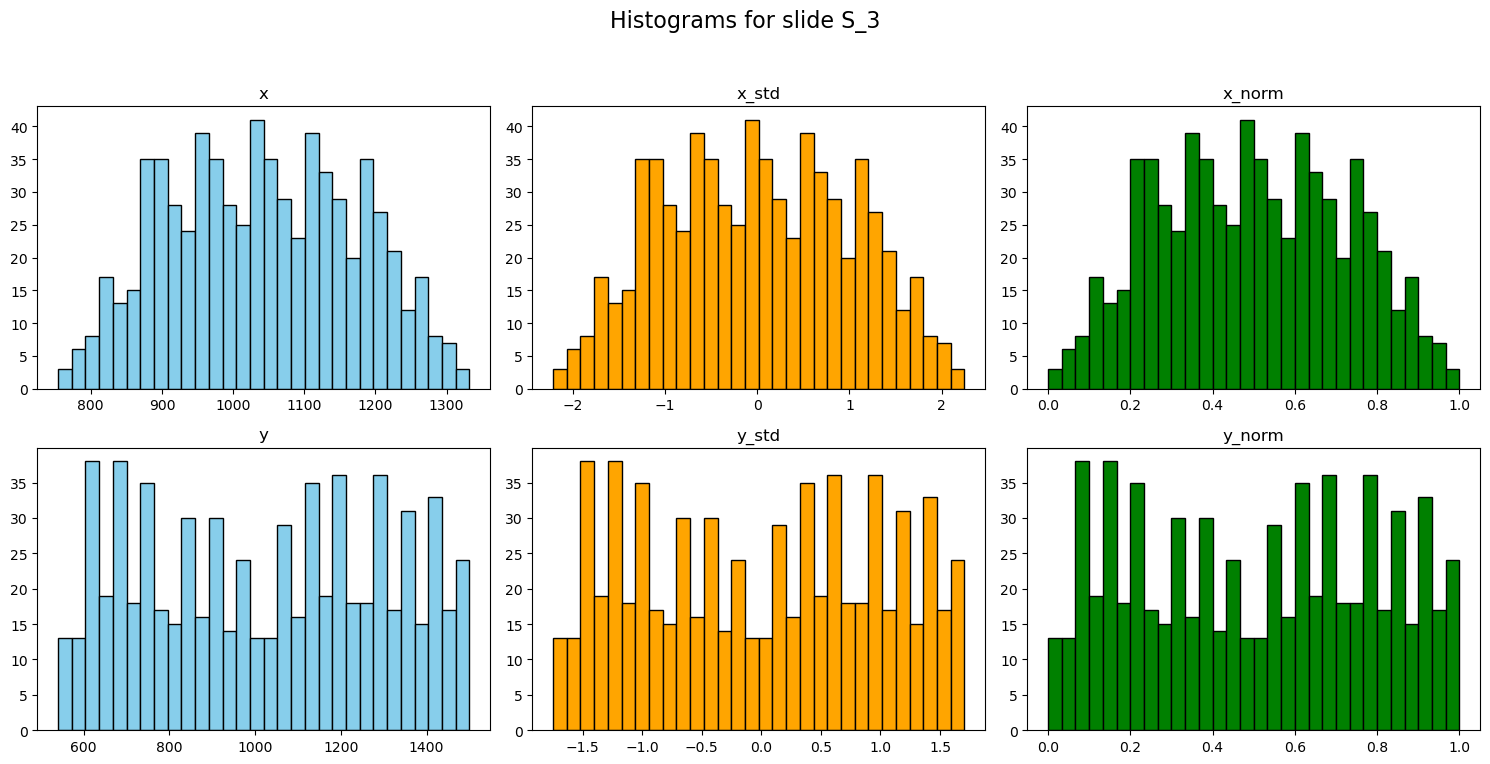

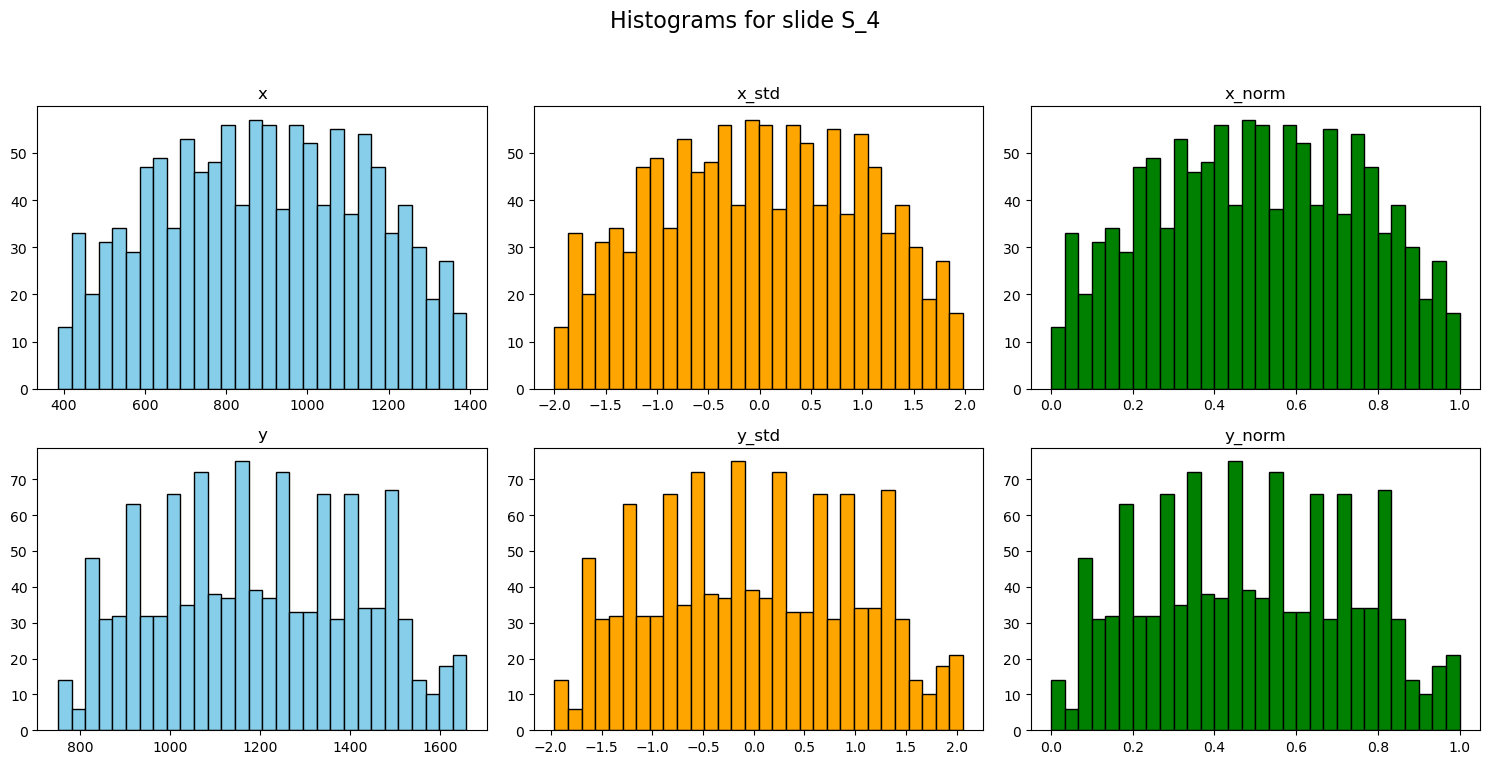

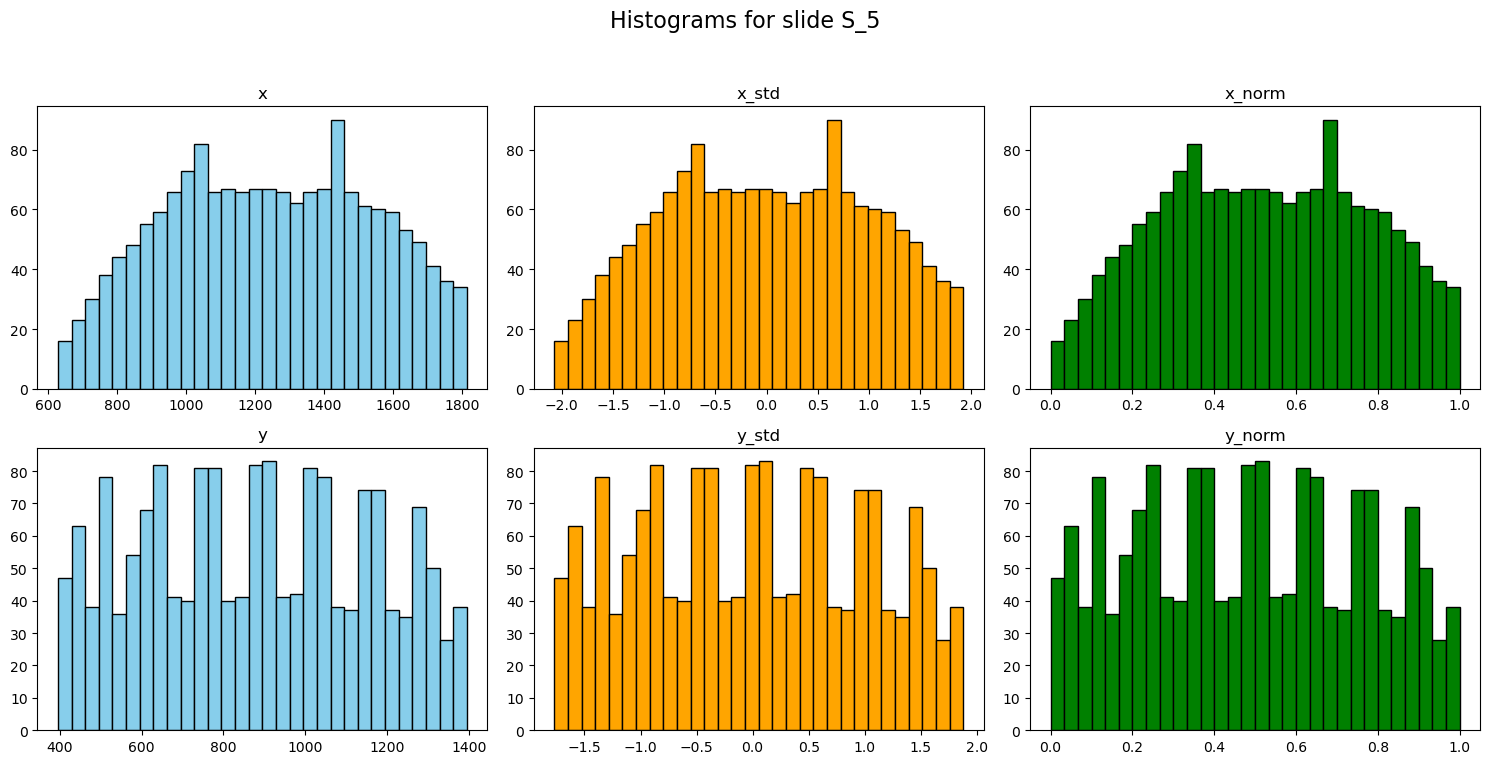

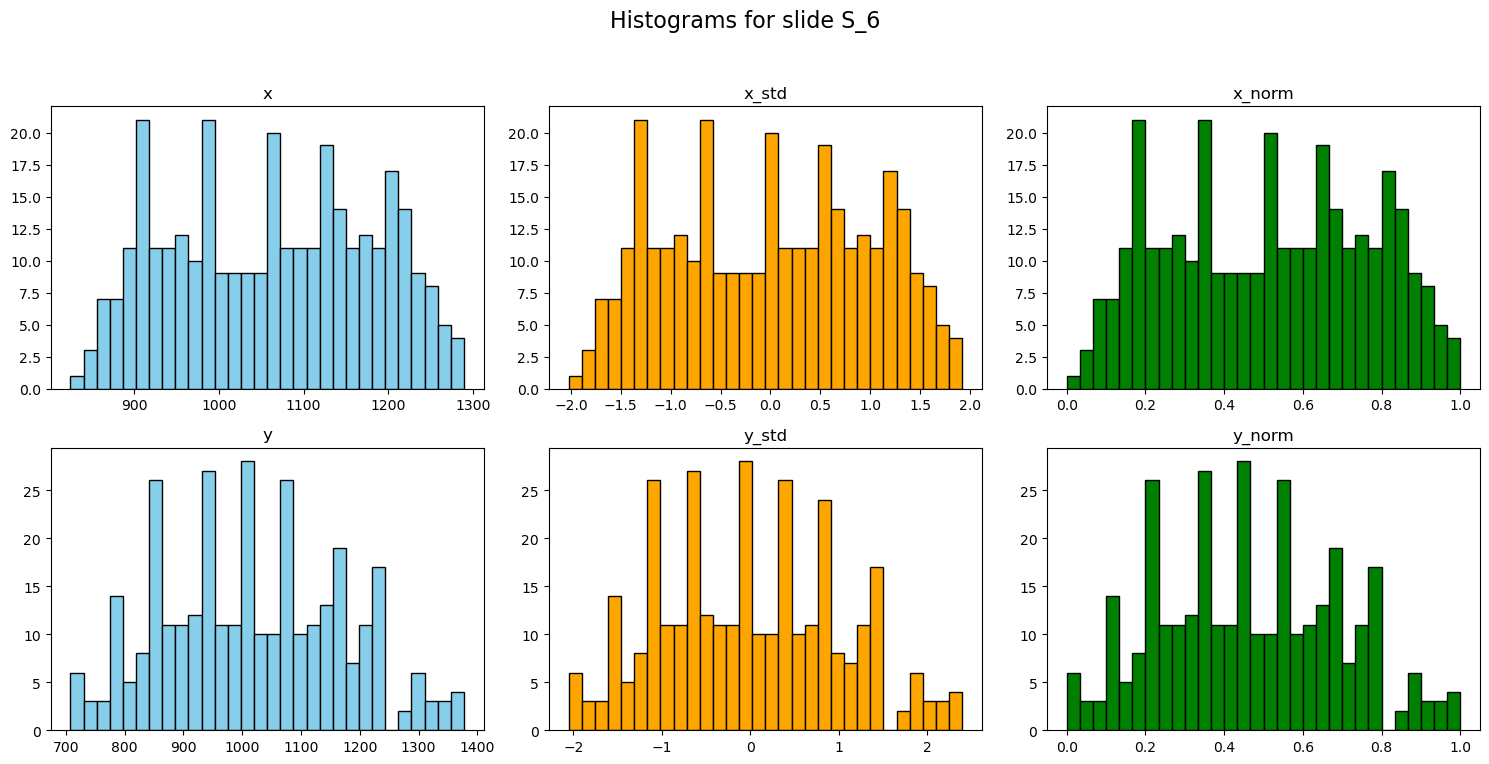

In [39]:
import matplotlib.pyplot as plt

def plot_histograms_by_slide(df):
    """
    依照 slide_id 分組，對每個 slide 畫出 x, y, x_std, y_std, x_norm, y_norm 的 histogram。
    df 應該包含以下欄位：slide_id, x, y, x_std, y_std, x_norm, y_norm
    """
    slides = df['slide_id'].unique()
    
    for slide in slides:
        df_slide = df[df['slide_id'] == slide]
        
        # 建立 2 x 3 的子圖 (2行3列)
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        fig.suptitle(f"Histograms for slide {slide}", fontsize=16)
        
        # 第一列：原始值與標準化、正規化 x
        axes[0, 0].hist(df_slide['x'], bins=30, color='skyblue', edgecolor='black')
        axes[0, 0].set_title("x")
        
        axes[0, 1].hist(df_slide['x_std'], bins=30, color='orange', edgecolor='black')
        axes[0, 1].set_title("x_std")
        
        axes[0, 2].hist(df_slide['x_norm'], bins=30, color='green', edgecolor='black')
        axes[0, 2].set_title("x_norm")
        
        # 第二列：y
        axes[1, 0].hist(df_slide['y'], bins=30, color='skyblue', edgecolor='black')
        axes[1, 0].set_title("y")
        
        axes[1, 1].hist(df_slide['y_std'], bins=30, color='orange', edgecolor='black')
        axes[1, 1].set_title("y_std")
        
        axes[1, 2].hist(df_slide['y_norm'], bins=30, color='green', edgecolor='black')
        axes[1, 2].set_title("y_norm")
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# 使用範例：
# 假設你已經用 scale_meta(meta) 得到一個 DataFrame df_scaled，
# 如此就可以呼叫：
plot_histograms_by_slide(df_scaled)


import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch
from torch.utils.data import Dataset
from torchvision import transforms

os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")

# 載入資料
center_tile = torch.load("./train_dataset_sep_v2/tiles.pt")
subtiles = torch.load("./train_dataset_sep_v2/subtiles.pt")
neighbor_tiles = torch.load("./train_dataset_sep_v2/neighbor_tiles.pt")
label = torch.load("./train_dataset_sep_v2/labels.pt")
meta = torch.load("./train_dataset_sep_v2/meta_info.pt")
graph_data = torch.load("./train_graph_dataset.pt")
# 正確方式
# ✅ 安全轉換：避免 ToTensor() 對 Tensor 失效
class SafeTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            return img  # 已是 Tensor，不再轉換
        return self.transform(img)

class importDataset(Dataset):
    def __init__(self):
            self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            return img  # 已是 Tensor，不再轉換
        return self.transform(img)
    def __init__(self, center_tile, subtiles, neighbor_tiles,label, node_feats, transform=None):
        """
        Custom Dataset to load image tiles, labels, and edge indices for training.
        
        Args:
            S_tiles (list): Small scale image tiles (spot-level features).
            M_tiles (list): Medium scale image tiles (spot-level features).
            L_tiles (list): Large scale image tiles (spot-level features).
            labels (list): Ground truth labels (spot-level cell type compositions).
            meta_info (list): Metadata containing slide_id, x, y coordinates for each spot.
            normal_coords (list): Normalized coordinates for each spot.
            slide_edge_indices (dict): Dictionary containing the slide-level edge indices for each slide.
        """
        self.center_tile = center_tile
        self.subtiles = subtiles
        self.neighbor_tiles = neighbor_tiles
        self.label = label
        self.node_feats = node_feats
        self.transform = transform or SafeTransform()

        # Optional: Apply any additional processing to the data here
        # e.g., scaling, normalization, etc.

    def __len__(self):
        # Return the number of samples (spots) in the dataset
        return len(self.center_tile)

    def __getitem__(self, idx):
        # Get the spot-level data for the sample at index `idx`
        
        # ✅ 安全轉換中心 tile
        center_tile = self.transform(self.center_tile[idx])  # shape: (3, H, W)

        # ✅ Subtiles: List of (H, W, 3)
        subtiles = torch.stack([self.transform(tile) for tile in self.subtiles[idx]])  # (9, 3, h, w)

        # ✅ Neighbor tiles: List of (H, W, 3)
        neighbor_tiles = torch.stack([self.transform(tile) for tile in self.neighbor_tiles[idx]])  # (8, 3, H, W)

        # ✅ Label
        label = torch.tensor(self.label[idx], dtype=torch.float32)

        # ✅ Normalized coordinates (x, y)

        node_feat = torch.tensor(self.node_feats[idx], dtype=torch.float) if self.node_feats is not None else None

        # Return the data in a PyTorch-friendly format as a dictionary
        return {
            'center_tile': center_tile,
            'subtiles': subtiles,
            'neighbor_tiles': neighbor_tiles,
            'label': label,
            'node_feat': node_feat
        }
train_dataset = importDataset(
    center_tile=center_tile,
    subtiles=subtiles,
    neighbor_tiles=neighbor_tiles,
    label=label,
    node_feats=graph_data['node_feats']
)

In [31]:
graph_data = torch.load("./train_graph_dataset.pt")
graph_data['node_feats'][0]


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_25126/1961644518.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data = torch.load("./train_graph_datase

tensor([0.8159, 0.5853, 1.0041, 0.6223, 0.6657, 0.3426, 0.4776, 0.8221, 0.5880,
        0.0165, 0.0158, 0.0231, 0.0173, 0.0322])

In [43]:
def check_dataset_item(dataset, idx=0):
    item = dataset[idx]

    print("🔍 Checking dataset sample:", idx)

    tile = item['center_tile']
    print(f"📏 Center tile shape: {tile.shape} | dtype: {tile.dtype} | min: {tile.min():.3f}, max: {tile.max():.3f}")
    assert tile.ndim == 3 and tile.shape[0] == 3, "❌ Center tile shape 不正確，應為 (3, H, W)"

    subtiles = item['subtiles']
    print(f"📏 Subtiles shape: {subtiles.shape} | dtype: {subtiles.dtype}")
    assert subtiles.shape[1] == 3, "❌ Subtile shape 不正確，應為 (9, 3, h, w)"

    neighbors = item['neighbor_tiles']
    print(f"📏 Neighbor tiles shape: {neighbors.shape} | dtype: {neighbors.dtype}")
    assert neighbors.shape[1] == 3, "❌ Neighbor tile shape 不正確，應為 (8, 3, H, W)"

    label = item['label']
    print(f"🧬 Label shape: {label.shape} | dtype: {label.dtype}")
    assert label.shape[0] == 35 and label.dtype == torch.float32, "❌ Label 應為 float32 且長度為 35"

    coordinates = item['meta']
    print(f"🧬 x: {coordinates[0]}, y: {coordinates[1]}")

    print("✅ All checks passed!")
    
check_dataset_item(train_dataset)


🔍 Checking dataset sample: 0
📏 Center tile shape: torch.Size([3, 78, 78]) | dtype: torch.float32 | min: -0.192, max: 0.953
📏 Subtiles shape: torch.Size([9, 3, 26, 26]) | dtype: torch.float32
📏 Neighbor tiles shape: torch.Size([8, 3, 78, 78]) | dtype: torch.float32
🧬 Label shape: torch.Size([35]) | dtype: torch.float32
🧬 x: 1.0151149150337258, y: 0.4681315452454167
✅ All checks passed!


In [84]:
train_dataset[0]

{'center_tile': tensor([[[ 0.6000,  0.4902,  0.3490,  ...,  0.2941,  0.2863,  0.2392],
          [ 0.6314,  0.5608,  0.4118,  ...,  0.2784,  0.2706,  0.2157],
          [ 0.7098,  0.6157,  0.4902,  ...,  0.3020,  0.2941,  0.2549],
          ...,
          [ 0.6549,  0.6549,  0.7255,  ...,  0.4039,  0.4039,  0.4275],
          [ 0.7412,  0.6941,  0.6549,  ...,  0.4353,  0.4118,  0.4353],
          [ 0.8118,  0.8039,  0.7255,  ...,  0.3647,  0.3569,  0.3725]],
 
         [[ 0.3569,  0.2471,  0.1059,  ...,  0.0118, -0.0039, -0.0510],
          [ 0.3882,  0.3176,  0.1686,  ..., -0.0039, -0.0196, -0.0745],
          [ 0.4588,  0.3647,  0.2392,  ...,  0.0275,  0.0118, -0.0275],
          ...,
          [ 0.4667,  0.4667,  0.5373,  ...,  0.1373,  0.1216,  0.1451],
          [ 0.5529,  0.5059,  0.4667,  ...,  0.1686,  0.1294,  0.1529],
          [ 0.6235,  0.6157,  0.5373,  ...,  0.0980,  0.0745,  0.0902]],
 
         [[ 0.7020,  0.5843,  0.4353,  ...,  0.5294,  0.5373,  0.4902],
          [ 0

In [85]:
from torch.utils.data import DataLoader, random_split

# 設定比例
train_ratio = 0.8
val_ratio = 1 - train_ratio
total_len = len(train_dataset)
train_len = int(train_ratio * total_len)
val_len = total_len - train_len

# 拆分 Dataset
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=generator)

print(f"✅ Train: {len(train_set)} samples")
print(f"✅ Val: {len(val_set)} samples")

# 🔹 將其包成 DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)


✅ Train: 6679 samples
✅ Val: 1670 samples


Poteintial issues:
# 1. my val_set tiles image may be included in the sub_tiles of train_set

Note: Since neighbor tiles are reused across samples, some mild information overlap may exist between train and val sets. However, final test set is completely held out.

# Neural Network

In [46]:
import torch
import torch.nn as nn

class CNNEncoder(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64, out_dim)

    def forward(self, x):  # x: (B, 3, H, W)
        x = self.cnn(x)     # → (B, 64, 1, 1)
        x = self.flatten(x) # → (B, 64)
        x = self.linear(x)  # → (B, out_dim)
        return x

class MLPDecoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)  # 👉 Linear activation
        )

    def forward(self, x):
        return self.mlp(x)

class VisionMLPModelWithCoord(nn.Module):
    def __init__(self, cnn_out_dim=64, output_dim=35):
        super().__init__()
        self.encoder_spot = CNNEncoder(cnn_out_dim)
        self.encoder_subtiles = CNNEncoder(cnn_out_dim)
        self.encoder_neighbors = CNNEncoder(cnn_out_dim)

        # Input to decoder: 3 * cnn_out_dim + 2 (for x, y)
        self.decoder = MLPDecoder(input_dim=cnn_out_dim * 3 + 2, output_dim=output_dim)

    def forward(self, center_tile, subtiles, neighbor_tiles, coords):
        # center_tile: (B, 3, H, W)
        # subtiles: (B, 9, 3, h, w)
        # neighbor_tiles: (B, 8, 3, H, W)
        # coords: (B, 2)
        B = center_tile.size(0)

        # Spot
        f_center = self.encoder_spot(center_tile)  # (B, D)

        # Subtiles
        B, N, C, h, w = subtiles.shape
        subtiles = subtiles.view(B * N, C, h, w)
        f_sub = self.encoder_subtiles(subtiles).view(B, N, -1).mean(dim=1)  # (B, D)

        # Neighbors
        B, N, C, H, W = neighbor_tiles.shape
        neighbor_tiles = neighbor_tiles.view(B * N, C, H, W)
        f_neigh = self.encoder_neighbors(neighbor_tiles).view(B, N, -1).mean(dim=1)  # (B, D)
        
        # Concatenate with coordinates
        x = torch.cat([f_center, f_sub, f_neigh, coords], dim=1)  # (B, 3D+2)
        out = self.decoder(x)  # (B, 35)
        return out


In [7]:
import torch
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm

# 🧠 訓練一個 epoch
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc="Training", leave=False)

    for batch in pbar:
        center = batch['center_tile'].to(device)
        subtiles = batch['subtiles'].to(device)
        neighbors = batch['neighbor_tiles'].to(device)
        label = batch['label'].to(device)

        # ✅ 處理 normalized coords (meta is a list of [x, y])
        #coords = torch.stack(batch['meta']).to(torch.float32).to(device)  # ✅ (B, 2)
        #coords = coords.view(-1, 2)
        coords = torch.stack(batch['node_feat']).to(device)   # (B, 14)
        coords = coords.squeeze(0)  # 現在 coords shape 變成 [32, 14]

        optimizer.zero_grad()
        out = model(center, subtiles, neighbors, coords)
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * center.size(0)
        avg_loss = total_loss / ((pbar.n + 1) * dataloader.batch_size)
        pbar.set_postfix(loss=loss.item(), avg=avg_loss)

    return total_loss / len(dataloader.dataset)

# 📏 驗證模型
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    preds, targets = [], []

    pbar = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch in pbar:
            center = batch['center_tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            neighbors = batch['neighbor_tiles'].to(device)
            label = batch['label'].to(device)

            ##coords = torch.stack(batch['meta']).to(torch.float32).to(device)  # ✅ (B, 2)
            #coords = coords.view(-1, 2)
            coords = torch.stack(batch['node_feat']).to(device)   # (B, 14)
            coords = coords.squeeze(0)  # 現在 coords shape 變成 [32, 14]

            out = model(center, subtiles, neighbors, coords)
            loss = loss_fn(out, label)

            total_loss += loss.item() * center.size(0)
            preds.append(out.cpu())
            targets.append(label.cpu())

            pbar.set_postfix(loss=loss.item())

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    # ✅ Spearman correlation for each gene
    scores = [spearmanr(preds[:, i], targets[:, i])[0] for i in range(preds.shape[1])]
    spearman_avg = np.nanmean(scores)

    return total_loss / len(dataloader.dataset), spearman_avg

# 🔮 預測
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_meta = []

    with torch.no_grad():
        for batch in dataloader:
            center = batch['center_tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            neighbors = batch['neighbor_tiles'].to(device)
            coords = torch.stack(batch['node_feat']).to(device)   # (B, 14)
            coords = coords.squeeze(0)  # 現在 coords shape 變成 [32, 14]

            #coords = torch.stack(batch['meta']).to(torch.float32).to(device)  # ✅ (B, 2)
            #coords = coords.view(-1, 2)

            out = model(center, subtiles, neighbors, coords)
            all_preds.append(out.cpu())

    return torch.cat(all_preds).numpy(), all_meta


# callback

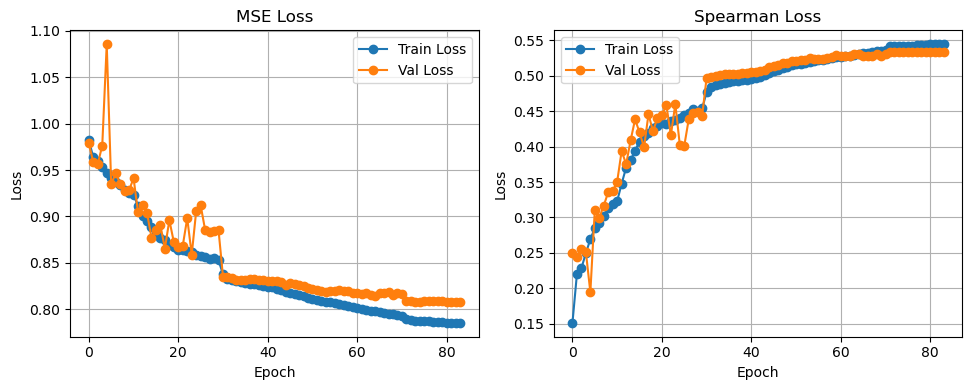

EarlyStopping counter: 10/10
⛔ Early stopping triggered.


In [86]:
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from operate_model import get_model_inputs,train_one_epoch,evaluate,predict,EarlyStopping,plot_losses

# 還可以用 ops["get_model_inputs"] 當需要時使用

# 🔧 設定裝置
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 🔧 初始化模型 & 優化器
model = VisionMLPModelWithCoord().to(device)
get_model_inputs(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
#loss_fn = spearman_loss

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopper = EarlyStopping(patience=10)

# 🔧 儲存 log 的設定
log_file = open("training_log.csv", mode="w", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Spearman", "Learning Rate"])

# 🔧 用來畫圖
train_losses = []
val_losses = []

train_spearmanes = []
val_spearmanes = []
# 🔁 開始訓練
num_epochs = 150
best_val_loss = float('inf')
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
display(fig)

for epoch in range(num_epochs):
    train_loss, train_spearman = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_spearman = evaluate(model, val_loader, loss_fn, device)

    # ✅ 儲存最好的模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Saved best model!")

    # ✅ 調整學習率
    scheduler.step(val_loss)

    # ✅ 寫入 CSV log
    lr = optimizer.param_groups[0]['lr']
    csv_writer.writerow([epoch+1, train_loss, val_loss, val_spearman, lr])

    # ✅ 印 epoch 結果
    print(f"Epoch {epoch+1}/{num_epochs} | loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | ρ: {val_spearman:.4f} | lr: {lr:.2e}")

    # ✅ 更新 loss list 並畫圖

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_spearmanes.append(train_spearman)
    val_spearmanes.append(val_spearman)
    
    # 更新 Loss 圖
    axes[0].clear()  # 清除之前的繪圖
    plot_losses(train_losses, val_losses, ax=axes[0], title="MSE Loss")

    # 更新 Spearman 圖
    axes[1].clear()
    plot_losses(train_spearmanes, val_spearmanes, ax=axes[1], title="Spearman Loss")
    
    plt.tight_layout()
    plt.show()
    clear_output(wait=True)  # 清除之前的輸出
    display(fig)
    plt.pause(0.1)  # 暫停一下以便更新畫面

    # ✅ Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⛔ Early stopping triggered.")
        break

# ✅ 關閉 log 檔案
log_file.close()


＃# Prediction

In [87]:
# ===== 需要的 Libraries =====
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import csv

# ===== 載入訓練好的模型權重 =====
from hevisum_dataset import importDataset

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

model.load_state_dict(torch.load("./best_model.pt"))
model.eval()


✅ Using device: mps


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_25126/2149826985.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./best_mod

VisionMLPModelWithCoord(
  (encoder_spot): CNNEncoder(
    (cnn): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): AdaptiveAvgPool2d(output_size=(1, 1))
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (encoder_subtiles

In [88]:

# ✅ 安全轉換：避免 ToTensor() 對 Tensor 失效
class SafeTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            return img  # 已是 Tensor，不再轉換
        return self.transform(img)

# ✅ Dataset 定義
class importDataset(Dataset):
    def __init__(self, center_tile, subtiles, neighbor_tiles, label, meta=None, transform=None):
        self.center_tile = center_tile
        self.subtiles = subtiles
        self.neighbor_tiles = neighbor_tiles
        self.label = label
        self.meta = meta if meta is not None else [None] * len(center_tile)

        self.transform = transform or SafeTransform()

    def __len__(self):
        return len(self.center_tile)

    def __getitem__(self, idx):
        # ✅ 安全轉換中心 tile
        center_tile = self.transform(self.center_tile[idx])  # shape: (3, H, W)

        # ✅ Subtiles: List of (H, W, 3)
        subtiles = torch.stack([self.transform(tile) for tile in self.subtiles[idx]])  # (9, 3, h, w)

        # ✅ Neighbor tiles: List of (H, W, 3)
        neighbor_tiles = torch.stack([self.transform(tile) for tile in self.neighbor_tiles[idx]])  # (8, 3, H, W)

        # ✅ Label
        label = torch.tensor(self.label[idx], dtype=torch.float32)

        # ✅ Normalized coordinates (x, y)
        meta = self.meta[idx]  # already normalized
        meta_tensor = torch.tensor(meta, dtype=torch.float)


        return {
            'center_tile': center_tile,
            'subtiles': subtiles,
            'neighbor_tiles': neighbor_tiles,
            'label': label,
            'coords': meta_tensor
        }
test_data = torch.load("./test_dataset.pt")
test_df_scaled = scale_meta(test_data['meta_info'])
print(df_scaled)
test_dataset = importDataset(
    center_tile=test_data['tiles'],
    subtiles=test_data['subtiles'],
    neighbor_tiles=test_data['neighbor_tiles'],
    label=np.zeros((len(test_data['tiles']), 35)),  # dummy label
    meta=test_df_scaled[['x_norm', 'y_norm']].astype(float).to_numpy()
)

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_25126/2977732085.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("./test_dataset.pt")


     slide_id     x     y     x_std     y_std    x_norm    y_norm
0         S_1  1554  1297  1.015115  0.468132  0.815877  0.585326
1         S_1   462  1502 -1.706209  1.191686  0.087392  0.754328
2         S_1  1488  1548  0.850639  1.354045  0.771848  0.792251
3         S_1  1725  1182  1.441256  0.062235  0.929953  0.490519
4         S_1   581  1113 -1.409655 -0.181303  0.166778  0.433636
...       ...   ...   ...       ...       ...       ...       ...
8344      S_6  1173   842  0.935331 -1.162485      0.75  0.200299
8345      S_6  1237   775  1.479388 -1.608359  0.887931  0.100149
8346      S_6   903   953 -1.359909 -0.423799  0.168103  0.366218
8347      S_6   954  1310 -0.926364  1.951975  0.278017  0.899851
8348      S_6  1186   864  1.045843 -1.016079  0.778017  0.233184

[8349 rows x 7 columns]


In [76]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [89]:
test_dataset[0]

{'center_tile': tensor([[[0.6627, 0.6235, 0.6000,  ..., 0.8118, 0.8118, 0.8039],
          [0.7176, 0.6471, 0.6314,  ..., 0.7490, 0.7412, 0.7412],
          [0.7725, 0.7333, 0.7255,  ..., 0.6627, 0.6706, 0.6784],
          ...,
          [0.6392, 0.5294, 0.4196,  ..., 1.0000, 0.9765, 0.9137],
          [0.6392, 0.5373, 0.4431,  ..., 1.0000, 0.9843, 0.9529],
          [0.6627, 0.5608, 0.4824,  ..., 0.9608, 0.9608, 0.9529]],
 
         [[0.4431, 0.4039, 0.3804,  ..., 0.5137, 0.5137, 0.5059],
          [0.5137, 0.4431, 0.4275,  ..., 0.5059, 0.4980, 0.4980],
          [0.5765, 0.5373, 0.5294,  ..., 0.4275, 0.4353, 0.4431],
          ...,
          [0.3961, 0.2863, 0.1765,  ..., 0.7725, 0.7490, 0.6863],
          [0.3882, 0.2863, 0.1922,  ..., 0.7725, 0.7569, 0.7255],
          [0.4196, 0.3098, 0.2314,  ..., 0.7333, 0.7333, 0.7255]],
 
         [[0.7176, 0.6784, 0.6549,  ..., 0.7725, 0.7725, 0.7647],
          [0.8039, 0.7333, 0.7176,  ..., 0.7412, 0.7333, 0.7333],
          [0.8431, 0.8039

In [ ]:
# 正確方式

raw_coords = []
for _meta in test_data['meta_info']:
    if _meta is not None:
        _, x, y = _meta
    else:
        x, y = 0, 0
    raw_coords.append([x, y])

raw_coords = np.array(raw_coords)


coord_scaler = StandardScaler()
normalized_coords = coord_scaler.fit_transform(raw_coords)

# ====== Step 2: 建立 Dataset ======
test_dataset = importDataset(
    center_tile=test_data['tiles'],
    subtiles=test_data['subtiles'],
    neighbor_tiles=test_data['neighbor_tiles'],
    label=np.zeros((len(test_data['tiles']), 35)),  # dummy label
    meta=normalized_coords
)


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_85179/984921605.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("../test_dataset.pt")


In [90]:
test_preds = predict(model, test_loader, device)


In [93]:
test_preds

array([[-0.50531554,  1.3433596 , -0.36959076, ...,  0.6992624 ,
         1.0667155 ,  1.0731885 ],
       [-0.3066737 ,  1.7276028 , -0.11883691, ...,  0.6356604 ,
         0.7806695 ,  1.3318541 ],
       [ 2.5736048 , -0.9990951 ,  2.3809388 , ..., -0.53300667,
         0.5083197 , -0.07627928],
       ...,
       [ 0.22497565, -0.38909814,  0.2565626 , ..., -0.10812673,
        -0.38676855, -0.57559216],
       [ 0.7598402 , -0.07050502,  0.74871826, ...,  0.31519344,
         0.702511  ,  1.0821053 ],
       [ 1.3844723 , -0.70164156,  1.3178363 , ..., -0.33409876,
         0.01571906, -0.33073413]], dtype=float32)

In [94]:
import os
from revert_predict_data import revert_prediction_array

test_preds＿re = revert_prediction_array(test_preds)

In [95]:
test_preds＿re

array([[ 2.92071104e-02,  1.98751092e-01,  5.58521748e-02, ...,
         8.84759426e-03,  1.83676481e-02,  8.36393833e-02],
       [ 9.69842672e-02,  2.32559204e-01,  1.14076257e-01, ...,
         8.37266445e-03,  1.51764154e-02,  9.49023962e-02],
       [ 1.76574492e+00,  1.17970705e-02,  9.02441502e-01, ...,
        -3.13580036e-04,  1.21473074e-02,  3.49735022e-02],
       ...,
       [ 3.01160693e-01,  5.74718714e-02,  2.07298398e-01, ...,
         2.83575058e-03,  2.25543976e-03,  1.45205259e-02],
       [ 5.44933558e-01,  8.21410418e-02,  3.41432571e-01, ...,
         5.98323345e-03,  1.43061876e-02,  8.40257406e-02],
       [ 8.88014793e-01,  3.38176489e-02,  5.15227914e-01, ...,
         1.15954876e-03,  6.69133663e-03,  2.44994164e-02]], dtype=float32)

In [96]:
import h5py

# ==== 讀取 test spot index 用於對應 ID ====
with h5py.File("./elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    test_spot_table = pd.DataFrame(np.array(test_spots['S_7']))  # Example: S_7


ensemble_df = pd.DataFrame(test_preds＿re, columns=[f"C{i+1}" for i in range(test_preds＿re.shape[1])])
ensemble_df.insert(0, 'ID', test_spot_table.index)
ensemble_df.to_csv("submission.csv", index=False)
print("✅ Saved submission.csv")


✅ Saved submission.csv
